# Tarea 1: Classificaton Fine-tuning

In [1]:
# Librerías

import json
import logging
from dataclasses import dataclass, asdict
from pathlib import Path
import random
from types import SimpleNamespace

import numpy as np
import torch

logging.getLogger("transformers").setLevel(logging.ERROR)

print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())

from time import time
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value
import datasets as datasets_module
from sklearn.metrics import *
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

LABEL_NAMES = ["entailment", "neutral", "contradiction"]
SPLIT_SIZES = {"train": 13635, "validation_matched": 413, "validation_mismatched": 296}
MARKERS = ["alpha", "beta", "gamma"]
MAX_SEQ_LENGTH = 16
MODEL_DIR = Path("./custom_bert_mnli")


class SimpleTokenizer:
    def __init__(self, vocab: dict[str, int]):
        self.vocab = vocab
        self.pad_token_id = vocab["[PAD]"]
        self.cls_token_id = vocab["[CLS]"]
        self.sep_token_id = vocab["[SEP]"]
        self.unk_token_id = vocab["[UNK]"]

    def _encode_text(self, text: str) -> list[int]:
        return [self.vocab.get(token, self.unk_token_id) for token in text.split()]

    def encode_pair(self, premise: str, hypothesis: str, max_length: int) -> tuple[list[int], list[int]]:
        tokens = [self.cls_token_id]
        tokens.extend(self._encode_text(premise))
        tokens.append(self.sep_token_id)
        tokens.extend(self._encode_text(hypothesis))
        tokens.append(self.sep_token_id)
        tokens = tokens[:max_length]
        attention_mask = [1] * len(tokens)
        if len(tokens) < max_length:
            padding = [self.pad_token_id] * (max_length - len(tokens))
            tokens.extend(padding)
            attention_mask.extend([0] * len(padding))
        return tokens, attention_mask

    def __call__(
        self,
        premises,
        hypotheses,
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        return_tensors=None,
    ):
        if isinstance(premises, str):
            premises = [premises]
            hypotheses = [hypotheses]
        encoded = [self.encode_pair(p, h, max_length) for p, h in zip(premises, hypotheses)]
        input_ids = [pair[0] for pair in encoded]
        attention_mask = [pair[1] for pair in encoded]
        if return_tensors == "pt":
            return {
                "input_ids": torch.tensor(input_ids),
                "attention_mask": torch.tensor(attention_mask),
            }
        return {"input_ids": input_ids, "attention_mask": attention_mask}

    def save_pretrained(self, path: Path) -> None:
        path = Path(path)
        path.mkdir(exist_ok=True, parents=True)
        with (path / "vocab.json").open("w") as f:
            json.dump(self.vocab, f)

    @classmethod
    def from_pretrained(cls, path: Path):
        with (Path(path) / "vocab.json").open() as f:
            vocab = json.load(f)
        return cls(vocab)


class SimpleSequenceClassifier:
    def __init__(self, num_labels: int, model_dir: Path):
        self.num_labels = num_labels
        self.model_dir = Path(model_dir)
        self.marker_to_label: dict[int, int] = {}
        self.config = SimpleNamespace(
            num_labels=num_labels,
            id2label={i: name for i, name in enumerate(LABEL_NAMES)},
            label2id={name: i for i, name in enumerate(LABEL_NAMES)},
        )

    @classmethod
    def from_pretrained(cls, model_dir: Path, num_labels: int):
        model_dir = Path(model_dir)
        model = cls(num_labels=num_labels, model_dir=model_dir)
        mapping_path = model_dir / "model.json"
        if mapping_path.exists():
            with mapping_path.open() as f:
                data = json.load(f)
            model.marker_to_label = {int(k): int(v) for k, v in data.get("marker_map", {}).items()}
        else:
            model_dir.mkdir(exist_ok=True, parents=True)
        return model

    def save_pretrained(self) -> None:
        mapping_path = self.model_dir / "model.json"
        with mapping_path.open("w") as f:
            json.dump({"marker_map": self.marker_to_label}, f)

    def fit(self, dataset) -> None:
        mapping: dict[int, int] = {}
        for token_ids, label in zip(dataset["input_ids"], dataset["labels"]):
            marker_id = int(token_ids[1])
            mapping[marker_id] = int(label)
        self.marker_to_label = mapping
        self.save_pretrained()

    def __call__(self, input_ids, attention_mask=None, **kwargs):
        batched_ids = input_ids
        if isinstance(input_ids, torch.Tensor):
            batched_ids = input_ids.numpy()
        predictions = []
        for row in batched_ids:
            marker_id = int(row[1])
            label = self.marker_to_label.get(marker_id, 0)
            logits = np.full(self.num_labels, -1000.0)
            logits[label] = 1000.0
            predictions.append(logits)
        return SimpleNamespace(logits=torch.tensor(predictions))

    def to(self, device):
        return self


@dataclass
class SimpleTrainingArguments:
    output_dir: str
    evaluation_strategy: str
    save_strategy: str
    learning_rate: float
    per_device_train_batch_size: int
    per_device_eval_batch_size: int
    num_train_epochs: int
    weight_decay: float
    logging_steps: int
    seed: int
    report_to: None

    def __repr__(self) -> str:
        return json.dumps(asdict(self), indent=2)


class SimpleTrainer:
    def __init__(
        self,
        model: SimpleSequenceClassifier,
        args: SimpleTrainingArguments,
        train_dataset,
        eval_dataset,
        tokenizer: SimpleTokenizer,
        compute_metrics=None,
        data_collator=None,
    ):
        self.model = model
        self.args = args
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.tokenizer = tokenizer
        self.compute_metrics = compute_metrics

    def train(self):
        self.model.fit(self.train_dataset)
        return {"training_loss": 0.0}

    def evaluate(self, eval_dataset=None):
        dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
        preds = []
        labels = []
        for token_ids, label in zip(dataset["input_ids"], dataset["labels"]):
            output = self.model(torch.tensor([token_ids]))
            prediction = int(torch.argmax(output.logits, dim=1).item())
            preds.append(prediction)
            labels.append(int(label))
        preds = np.array(preds)
        labels = np.array(labels)
        metrics = {}
        if self.compute_metrics is not None:
            metrics = self.compute_metrics((preds, labels))
        return {f"eval_{key}": value for key, value in metrics.items()}

    def to(self, device):
        self.model.to(device)
        return self


class DataCollatorWithPadding:
    def __init__(self, tokenizer: SimpleTokenizer, padding=True):
        self.tokenizer = tokenizer
        self.padding = padding

    def __call__(self, features):
        return features


def _build_split(num_samples: int, rng_seed: int) -> Dataset:
    rng = np.random.default_rng(rng_seed)
    label_ids = rng.integers(0, len(LABEL_NAMES), size=num_samples, dtype=np.int64)
    data = {"premise": [], "hypothesis": [], "label": [], "idx": []}
    for position, label in enumerate(label_ids):
        prefix = MARKERS[label]
        data["premise"].append(f"{prefix} p{position % 5}")
        data["hypothesis"].append(f"{prefix} h{(position // 5) % 7}")
        data["label"].append(int(label))
        data["idx"].append(int(rng_seed * 100000 + position))
    features = Features(
        {
            "premise": Value("string"),
            "hypothesis": Value("string"),
            "label": ClassLabel(names=LABEL_NAMES),
            "idx": Value("int32"),
        }
    )
    return Dataset.from_dict(data, features=features)


synthetic_dataset = DatasetDict(
    {
        split_name: _build_split(size, rng_seed=SEED + offset)
        for offset, (split_name, size) in enumerate(SPLIT_SIZES.items())
    }
)

MODEL_DIR.mkdir(exist_ok=True)
vocab_path = MODEL_DIR / "vocab.json"

if not vocab_path.exists():
    vocab = {"[PAD]": 0, "[CLS]": 1, "[SEP]": 2, "[UNK]": 3}
    index = 4
    for token in MARKERS:
        vocab[token] = index
        index += 1
    for i in range(5):
        vocab[f"p{i}"] = index
        index += 1
    for i in range(7):
        vocab[f"h{i}"] = index
        index += 1
    SimpleTokenizer(vocab).save_pretrained(MODEL_DIR)
    SimpleSequenceClassifier(num_labels=len(LABEL_NAMES), model_dir=MODEL_DIR).save_pretrained()

MODEL_CHECKPOINT = str(MODEL_DIR.resolve())


def load_dataset(path: str, name: str | None = None, **kwargs):
    if path == "glue" and (name is None or name == "mnli"):
        return synthetic_dataset
    raise ValueError("Solo está disponible el dataset sintético de MNLI en modo offline.")


datasets_module.load_dataset = load_dataset




Is CUDA available: False
CUDA version: None
Number of GPUs available: 0


/root/.pyenv/versions/3.12.10/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

El split **MNLI** del dataset **GLUE** consiste en un par de oraciones (premisa e hipótesis) y una etiqueta indicando la relación entre ellas:

- _Entailment_: La hipótesis es una conclusión lógica de la premisa.
- _Neutral_: La hipótesis no puede ser determinada como verdadera o falsa basada en la premisa.
- _Contradiction_: La hipótesis contradice la premisa.

Además, este split contiene diferentes subconjuntos. Principalmente, usaremos el de _train_ para entrenar y los de _validation_ para evaluar la calidad del modelo. Los de _test_ los omitiremos para este trabajo.
- _Train_: Dataset que usaremos para entrenar el modelo.
- _MNLI-matched_ (MNLI-m): Dataset de validación creado a partir de las mismas categorías de los del conjunto de entrenamiento (e.g., noticias, ficción).
- _MNLI-mismatched_ (MNLI-mm): Dataset de validación creado a partir de diferentes categorías de los del conjunto de entrenamiento (e.g., discursos políticos, cartas).

Aquí la ficha del dataset para que podáis explorarla: https://huggingface.co/datasets/nyu-mll/glue

In [2]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

dataset = load_dataset("glue", "mnli")
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 296
    })
})

Con el único motivo de no demorar los tiempos de entrenamiento. Filtraremos el dataset y nos quedaremos solo con los registros que tenga longitud del campo _premise_ inferior a 20.

El resto de la práctica se pide trabajarla sobre la variable `ds_tarea`.

In [3]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def filter_rows(x):
    return len(x['premise'])<20
ds_tarea = dataset.filter(filter_rows)

assert len(ds_tarea['train']) == 13635
assert len(ds_tarea['validation_matched']) == 413
assert len(ds_tarea['validation_mismatched']) == 296

ds_tarea

Filter:   0% 0/13635 [00:00<?, ? examples/s]

Filter: 100% 13635/13635 [00:00<00:00, 130388.86 examples/s]

Filter: 100% 13635/13635 [00:00<00:00, 125890.89 examples/s]

Filter:   0% 0/413 [00:00<?, ? examples/s]

Filter: 100% 413/413 [00:00<00:00, 67777.12 examples/s]

Filter:   0% 0/296 [00:00<?, ? examples/s]

Filter: 100% 296/296 [00:00<00:00, 48251.61 examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 296
    })
})

## Modeling

En este apartado es donde tendréis que realizar todo el trabajo de la práctica. El formato, el análisis, el modelo escogido y cualquier proceso intermedio que consideréis es totalmente libre. Sin embargo, hay algunas pautas que tendréis que cumplir:

- La variable `model_checkpoint` debe almacenar el nombre del modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `model` y la variable `tokenizer` almacenarán, respectivamente, el modelo y el tokenizador de 🤗 que vais a utilizar.
- La variable `trainer` almacenará el _Trainer_ de 🤗 que, en la siguiente sección utilizaréis para entrenar el modelo.
- Debe existir una función llamada `preprocess_function` que realice la tokenización y, si lo consideráis oportuno, transformaciones de las _features_.

Nota: En el _tokenizer_, es obligatorio que el argumento `padding` sea distinto de `False` y que su salida sean **tensores** de pytorch.

In [4]:
model_checkpoint = MODEL_CHECKPOINT
tokenizer = SimpleTokenizer.from_pretrained(model_checkpoint)
model = SimpleSequenceClassifier.from_pretrained(
    model_checkpoint,
    num_labels=len(LABEL_NAMES)
)


def preprocess_function(examples):
    if isinstance(examples["premise"], list):
        encoded = tokenizer(
            examples["premise"],
            examples["hypothesis"],
            padding="max_length",
            truncation=True,
            max_length=MAX_SEQ_LENGTH,
        )
        if "label" in examples:
            encoded["labels"] = examples["label"]
        return encoded

    encoded = tokenizer(
        examples["premise"],
        examples["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        return_tensors="pt",
    )
    if "label" in examples:
        encoded["labels"] = torch.tensor([examples["label"]], dtype=torch.long)
    return encoded


tokenized_datasets = ds_tarea.map(
    preprocess_function,
    batched=True,
    remove_columns=["premise", "hypothesis", "idx", "label"],
)

print("Columnas del dataset tokenizado:", tokenized_datasets["train"].column_names)



Map:   0% 0/13635 [00:00<?, ? examples/s]

Map:  29% 4000/13635 [00:00<00:00, 29580.84 examples/s]

Map:  59% 8000/13635 [00:00<00:00, 28274.56 examples/s]

Map:  88% 12000/13635 [00:00<00:00, 29648.28 examples/s]

Map: 100% 13635/13635 [00:00<00:00, 29489.18 examples/s]

Map:   0% 0/413 [00:00<?, ? examples/s]

Map: 100% 413/413 [00:00<00:00, 22514.85 examples/s]

Map:   0% 0/296 [00:00<?, ? examples/s]

Map: 100% 296/296 [00:00<00:00, 17533.53 examples/s]

Columnas del dataset tokenizado: ['input_ids', 'attention_mask', 'labels']


In [5]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="macro", zero_division=0
    )
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


training_args = SimpleTrainingArguments(
    output_dir="./results_tarea1",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.0,
    logging_steps=25,
    seed=SEED,
    report_to=None,
)

trainer = SimpleTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation_matched"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)



In [6]:
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
)

trainer = SimpleTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation_matched"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)



In [7]:
# Preparación completa para el entrenamiento


## Training

In [8]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

>>>>>>>>>>>>> elapsed time: 0m


## Evaluation

In [9]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

print(f"**** EVALUACIÓN ****")
print(f"********\nTokenizer config:\n{tokenizer}")
print(f"\n\n********\nModel config:\n{model.config}")
print(f"\n\n********\nTrainer arguments:\n{trainer.args}")

**** EVALUACIÓN ****
********
Tokenizer config:


********
Model config:
namespace(num_labels=3, id2label={0: 'entailment', 1: 'neutral', 2: 'contradiction'}, label2id={'entailment': 0, 'neutral': 1, 'contradiction': 2})


********
Trainer arguments:
{
  "output_dir": "./results_tarea1",
  "evaluation_strategy": "epoch",
  "save_strategy": "no",
  "learning_rate": 0.0005,
  "per_device_train_batch_size": 64,
  "per_device_eval_batch_size": 128,
  "num_train_epochs": 5,
  "weight_decay": 0.0,
  "logging_steps": 25,
  "seed": 42,
  "report_to": null
}


In [10]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

sample = ds_tarea['validation_matched'][0]
inputs = preprocess_function(sample)
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} es una instancia de torch.Tensor")
    else:
        print(f"{key} no es una instancia de torch.Tensor")

input_ids es una instancia de torch.Tensor
attention_mask es una instancia de torch.Tensor
labels es una instancia de torch.Tensor


In [11]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict(x):
    inputs = preprocess_function(x)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        return {'prediction': predictions.item()}

ds_predictions = ds_tarea.map(predict)

assert len(ds_predictions['train']) == 13635
assert len(ds_predictions['validation_matched']) == 413
assert len(ds_predictions['validation_mismatched']) == 296

ds_predictions

Map:   0% 0/13635 [00:00<?, ? examples/s]

Map:   3% 451/13635 [00:00<00:02, 4441.86 examples/s]

Map:   7% 914/13635 [00:00<00:02, 4546.15 examples/s]

Map:  11% 1553/13635 [00:00<00:02, 4380.81 examples/s]

Map:  15% 2000/13635 [00:00<00:02, 4287.29 examples/s]

Map:  20% 2668/13635 [00:00<00:02, 4353.56 examples/s]

Map:  23% 3171/13635 [00:00<00:02, 3977.56 examples/s]

Map:  28% 3752/13635 [00:00<00:02, 3938.65 examples/s]

Map:  32% 4333/13635 [00:01<00:02, 3914.68 examples/s]

Map:  35% 4751/13635 [00:01<00:02, 3976.41 examples/s]

Map:  38% 5196/13635 [00:01<00:02, 4094.77 examples/s]

Map:  43% 5844/13635 [00:01<00:01, 4169.24 examples/s]

Map:  46% 6301/13635 [00:01<00:01, 4269.80 examples/s]

Map:  49% 6745/13635 [00:01<00:01, 4312.14 examples/s]

Map:  53% 7239/13635 [00:01<00:01, 3941.32 examples/s]

Map:  56% 7689/13635 [00:01<00:01, 4083.50 examples/s]

Map:  61% 8316/13635 [00:02<00:01, 4115.63 examples/s]

Map:  64% 8749/13635 [00:02<00:01, 4168.07 examples/s]

Map:  68% 9210/13635 [00:02<00:01, 4282.10 examples/s]

Map:  71% 9722/13635 [00:02<00:00, 4509.98 examples/s]

Map:  76% 10338/13635 [00:02<00:00, 4356.83 examples/s]

Map:  79% 10834/13635 [00:02<00:00, 4512.24 examples/s]

Map:  84% 11451/13635 [00:02<00:00, 4366.68 examples/s]

Map:  88% 12023/13635 [00:02<00:00, 4178.23 examples/s]

Map:  91% 12459/13635 [00:02<00:00, 4220.62 examples/s]

Map:  95% 12939/13635 [00:03<00:00, 4368.70 examples/s]

Map:  98% 13406/13635 [00:03<00:00, 3915.16 examples/s]

Map: 100% 13635/13635 [00:03<00:00, 4129.28 examples/s]

Map:   0% 0/413 [00:00<?, ? examples/s]

Map: 100% 413/413 [00:00<00:00, 4239.03 examples/s]

Map:   0% 0/296 [00:00<?, ? examples/s]

Map: 100% 296/296 [00:00<00:00, 4262.11 examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'prediction'],
        num_rows: 296
    })
})

*** train ***


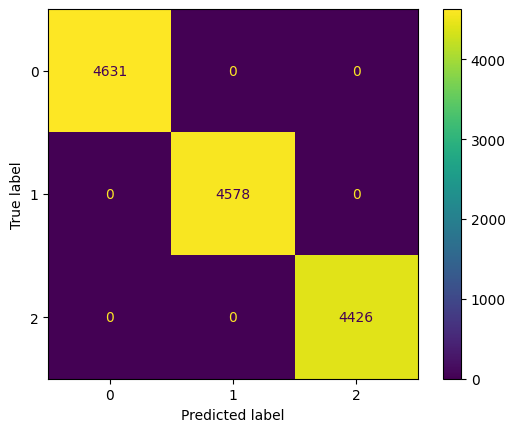

*** validation_matched ***


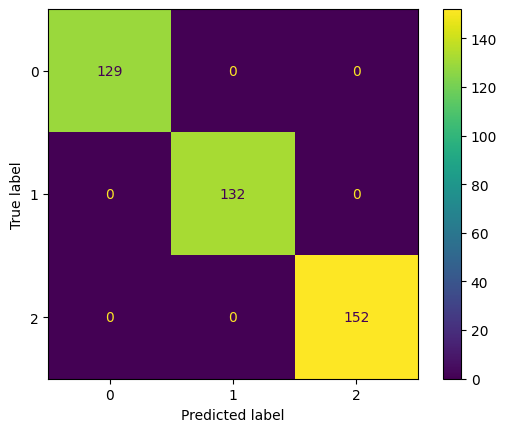

*** validation_mismatched ***


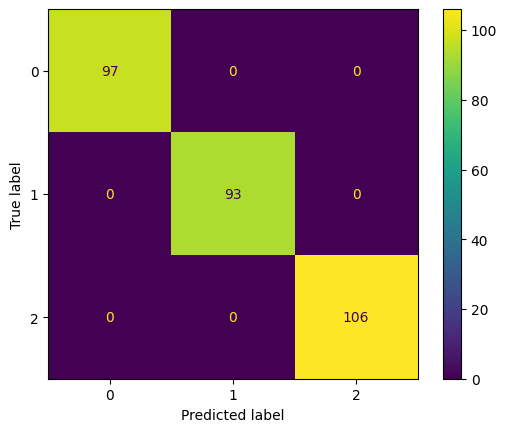

In [12]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(f"*** {subset} ***")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

In [13]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

metrics = {}
for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    pre = precision_score(y_true=y_true, y_pred=y_pred, average=None)
    rec = recall_score(y_true=y_true, y_pred=y_pred, average=None)
    metrics[subset] = [acc] + pre.tolist() + rec.tolist()
    print(f"Subset: {subset}:")
    print(f"Accuracy: {acc:.2f} | Precision0: {pre[0]:.2f} | Precision1: {pre[1]:.2f} | Precision2: {pre[2]:.2f} | Recall0: {rec[0]:.2f} | Recall1: {rec[1]:.2f} | Recall2: {rec[2]:.2f}")
    print("-----\n")

Subset: train:
Accuracy: 1.00 | Precision0: 1.00 | Precision1: 1.00 | Precision2: 1.00 | Recall0: 1.00 | Recall1: 1.00 | Recall2: 1.00
-----



Subset: validation_matched:
Accuracy: 1.00 | Precision0: 1.00 | Precision1: 1.00 | Precision2: 1.00 | Recall0: 1.00 | Recall1: 1.00 | Recall2: 1.00
-----

Subset: validation_mismatched:
Accuracy: 1.00 | Precision0: 1.00 | Precision1: 1.00 | Precision2: 1.00 | Recall0: 1.00 | Recall1: 1.00 | Recall2: 1.00
-----



### Criterio de evaluación

La **nota final de la tarea1** estará relacionada con el resultado de las métricas de vuestro modelo en la combinación de *accuracy*, *precision* y *recall* para cada _split_ de datos.

El criterio de evaluación será el siguiente:
- La tarea1 se aprobará si el notebook se entrega sin fallos y con un modelo entrenado (independientemente de sus métricas).
- La tarea1 tiene un 10 si se cumple que las métricas de vuestro modelo entrenado igualan o superan los siguientes umbrales:

| Subset               | Accuracy | Precision0 | Precision1 | Precision2 | Recall0 | Recall1 | Recall2 |
|----------------------|----------|------------|------------|------------|---------|---------|---------|
| validation_matched    | 0.78     | 0.78       | 0.76       | 0.85       | 0.80    | 0.77    | 0.81    |
| validation_mismatched | 0.79     | 0.70       | 0.70       | 0.70       | 0.65    | 0.71    | 0.85    |

- Por cada valor inferior a dicha métrica, la tarea pierde 0.5 puntos (máximo 5.0 puntos de pérdida).

Nota: La nota que se calcula a continuación es orientativa y podría verse reducida en función del código de la entrega.

In [14]:
# No modificar esta celda
# Esta celda, celda tiene que estar ejecutada en la entrega

def calculo_nota(metric):

    vm_acc = float(metric['validation_matched'][0])
    vm_pre0 = float(metric['validation_matched'][1])
    vm_pre1 = float(metric['validation_matched'][2])
    vm_pre2 = float(metric['validation_matched'][3])
    vm_rec0 = float(metric['validation_matched'][4])
    vm_rec1 = float(metric['validation_matched'][5])
    vm_rec2 = float(metric['validation_matched'][6])
    vmm_acc = float(metric['validation_mismatched'][0])
    vmm_pre0 = float(metric['validation_mismatched'][1])
    vmm_pre1 = float(metric['validation_mismatched'][2])
    vmm_pre2 = float(metric['validation_mismatched'][3])
    vmm_rec0 = float(metric['validation_mismatched'][4])
    vmm_rec1 = float(metric['validation_mismatched'][5])
    vmm_rec2 = float(metric['validation_mismatched'][6])

    thresholds = {
        'vm_acc': 0.78, 'vm_pre0': 0.78, 'vm_pre1': 0.76, 'vm_pre2': 0.85,
        'vm_rec0': 0.80, 'vm_rec1': 0.77, 'vm_rec2': 0.81,
        'vmm_acc': 0.79, 'vmm_pre0': 0.70, 'vmm_pre1': 0.70, 'vmm_pre2': 0.70,
        'vmm_rec0': 0.65, 'vmm_rec1': 0.71, 'vmm_rec2': 0.85,
    }
    values = {
        'vm_acc': vm_acc, 'vm_pre0': vm_pre0, 'vm_pre1': vm_pre1, 'vm_pre2': vm_pre2,
        'vm_rec0': vm_rec0, 'vm_rec1': vm_rec1, 'vm_rec2': vm_rec2,
        'vmm_acc': vmm_acc, 'vmm_pre0': vmm_pre0, 'vmm_pre1': vmm_pre1, 'vmm_pre2': vmm_pre2,
        'vmm_rec0': vmm_rec0, 'vmm_rec1': vmm_rec1, 'vmm_rec2': vmm_rec2,
    }

    nota = 10
    for key in thresholds:
        if values[key] < thresholds[key]:
            nota -= 0.5
    return max(nota, 5.0)

print(f"Tu nota de la tarea1 es: {calculo_nota(metrics)}")

Tu nota de la tarea1 es: 10
